In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

sns.set_style("white")
sns.set_context('notebook')

Using TensorFlow backend.


In [2]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [3]:
training_data.groupby('call').size()

call
a    13745
f     1600
g     3946
s    17781
dtype: int64

In [4]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [5]:
X.shape

(37072, 67)

In [6]:
Y.shape

(37072, 4)

In [7]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [8]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=67, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [10]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [11]:
predicted = cross_val_predict(estimator, X, Y, cv=kfold)

Epoch 1/10
33364/33364 [==============================] - 27s - loss: 0.7338 - acc: 0.6886    
Epoch 2/10
33364/33364 [==============================] - 28s - loss: 0.6121 - acc: 0.7531    
Epoch 3/10
33364/33364 [==============================] - 28s - loss: 0.5802 - acc: 0.7660    
Epoch 4/10
33364/33364 [==============================] - 29s - loss: 0.5619 - acc: 0.7734    
Epoch 5/10
33364/33364 [==============================] - 29s - loss: 0.5482 - acc: 0.7774    
Epoch 6/10
33364/33364 [==============================] - 29s - loss: 0.5378 - acc: 0.7822    
Epoch 7/10
33364/33364 [==============================] - 29s - loss: 0.5292 - acc: 0.7865    
Epoch 8/10
33364/33364 [==============================] - 30s - loss: 0.5251 - acc: 0.7875    
Epoch 9/10
33364/33364 [==============================] - 30s - loss: 0.5199 - acc: 0.7891    
Epoch 10/10
33364/33364 [==============================] - 31s - loss: 0.7351 - acc: 0.6891    
Epoch 2/10
33364/33364 [=========================

33365/33365 [==============================] - 30s - loss: 0.6141 - acc: 0.7522    
Epoch 3/10
33365/33365 [==============================] - 30s - loss: 0.5793 - acc: 0.7673    
Epoch 4/10
33365/33365 [==============================] - 26s - loss: 0.5618 - acc: 0.7718    
Epoch 5/10
33365/33365 [==============================] - 27s - loss: 0.5493 - acc: 0.7773    
Epoch 6/10
33365/33365 [==============================] - 26s - loss: 0.5378 - acc: 0.7825    
Epoch 7/10
33365/33365 [==============================] - 29s - loss: 0.5324 - acc: 0.7860    
Epoch 8/10
33365/33365 [==============================] - 29s - loss: 0.5268 - acc: 0.7872    
Epoch 9/10
33365/33365 [==============================] - 30s - loss: 0.5194 - acc: 0.7905    
Epoch 10/10
33365/33365 [==============================] - 30s - loss: 0.7278 - acc: 0.6936    
Epoch 2/10
33365/33365 [==============================] - 30s - loss: 0.6104 - acc: 0.7556    
Epoch 3/10
33365/33365 [==============================] - 30

In [12]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [13]:
metrics.accuracy_score(Y, predicted_transformed)

0.78617285282693139

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [14]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.79      0.75      0.77     13745
          1       0.55      0.46      0.50      1600
          2       0.59      0.80      0.68      3946
          3       0.86      0.84      0.85     17781

avg / total       0.79      0.79      0.79     37072



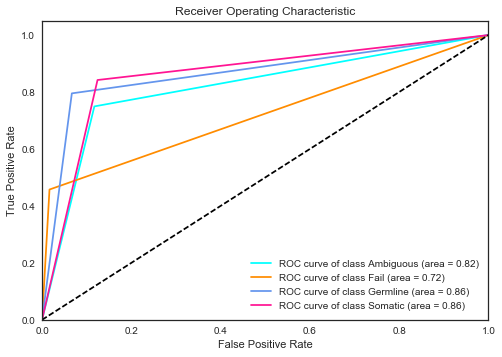

In [15]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], predicted_transformed[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()